In [1]:
%load_ext blackcellmagic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from dataclasses import asdict, dataclass
from pathlib import Path
import glob
import yaml
from datetime import date
from scipy import ndimage

import matplotlib.pyplot as plt

from itertools import combinations
from itertools import product

from src.imageprocessing import ImageProcessing
from src.roi import PlotCoordinates
from src.config import Config, CreateConfigurationYAMLExamples


In [2]:
# CreateConfigurationYAMLExamples()
config = Config(load_from_config=True, config_file="Potato_Fertilizer_Othello_Jul21_2020_config.yaml")
improc = ImageProcessing(data_export_path=config.data_export_path, data_import_path=config.data_import_path)

# create output folder for processed data
if os.path.isdir(Path.cwd() / config.data_export_path) == False:
    print(f"creating data export folder: {Path.cwd() / config.data_export_path}")
    os.mkdir(Path.cwd() / config.data_export_path)

# view config contents
for key, value in asdict(config).items():
    print(f"{key}: {value}")

creating data export folder: c:\data\remote_sensing\potato\data\processed\Jul21_2020
project_stub: Potato_Fertilizer_Othello
data_acquisition_date: Jul21_2020
NDVI_TH: 0.3
field_dim: (7400, 1600)
field_origin: (1350, 1445)
field_angle: 182.4
plot_shape: (200, 492)
edge_buf: 40
num_ranges: 13
plot_offset: (-20, 6)
image_format: *.tif
camera: rededge_mx_band_wl
camera_wl: {'blue': 475, 'blue-444': 444, 'green': 560, 'green-531': 531, 'nir': 842, 'red': 668, 'red-650': 650, 'red-edge': 717, 'red-edge-705': 705, 'red-edge-740': 740}
plot_export_path: c:\data\remote_sensing\potato/data/image_export/
ground_truth_path: c:\data\remote_sensing\potato/data/raw/ground_truth.csv
data_import_path: c:\data\remote_sensing\potato/data/raw/Jul21_2020
data_export_path: c:\data\remote_sensing\potato/data/processed/Jul21_2020
load_from_config: True
config_file: c:\data\remote_sensing\potato/config/Potato_Fertilizer_Othello_Jul21_2020_config.yaml


In [3]:
# check to see if all the images are there
expected_images = 10
found_images = len(list(Path(config.data_import_path).glob(config.image_format)))
print(f"(expected == found) = {expected_images ==  found_images}")

(expected == found) = True


# Rotate and crop to field of interest
1. Load nir channel image
2. Rotate the image to line up crops with axes
3. crop to field of interest
4. plot for visual verification

img.shape: (9971, 3601)
nir range: (0.0423862561583519,0.9645763039588928)


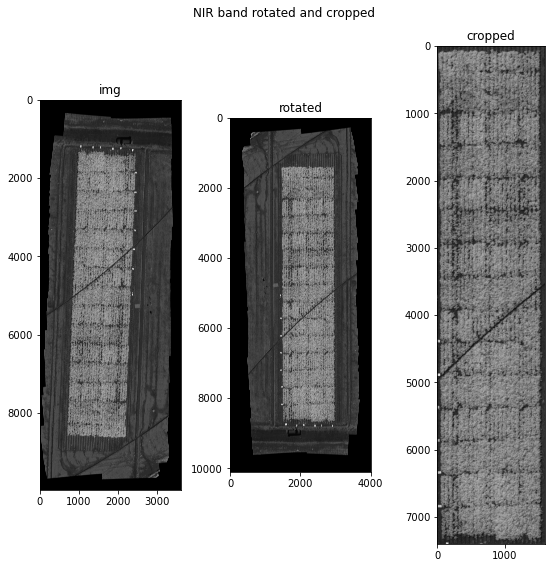

In [4]:
# 1.load nir channel as img array
img = improc.load_img("nir")
print(f"img.shape: {img.shape}")

# 2. rotate
img_rotate = ndimage.rotate(img, angle=config.field_angle, reshape=True, order=1)

# 3. crop to given values. if they work
y_min, x_min = config.field_origin
y_max, x_max = (config.field_origin[0] + config.field_dim[0], config.field_origin[1] + config.field_dim[1])

img_crop = img_rotate[y_min : y_max, x_min : x_max]

# 4. plot as one figure
fig, axs = plt.subplots(1, 3)
fig.suptitle("NIR band rotated and cropped")
fig.set_size_inches((8,8))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("img")

axs[1].imshow(img_rotate, cmap="gray")
axs[1].set_title("rotated")

axs[2].imshow(img_crop, cmap="gray")
axs[2].set_title("cropped")

fig.tight_layout()
print(f"nir range: ({np.min(img_crop)},{np.max(img_crop)})")



# Import full image stack
If the above images look good, we will next import all of the images into a numpy array stack. 

This code block uses list comprehension to create a list of rotated image arrays, and hands them to np.stack(), which returns an array with the shape of (channel, y, x). This can take a few minutes on some computers.



imported, rot field_image.shape: (10, 10113, 4015)
cropping it to field_image[:, 1350:8750, 1445:3045]
final field_image.shape: (10, 7400, 1600)
0 range: (0.0,0.6129849553108215)
1 range: (0.0,0.6193112134933472)
2 range: (0.0,0.5598080158233643)
3 range: (0.0,0.7270386815071106)
4 range: (0.0423862561583519,0.9645763039588928)
5 range: (0.0,0.830548882484436)
6 range: (0.0,0.8138675689697266)
7 range: (0.0,0.8576177358627319)
8 range: (0.0,0.8741737604141235)
9 range: (0.0,0.9337915778160095)


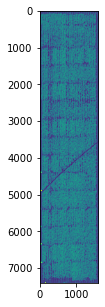

In [5]:
# set field parameters from config
y_min, x_min = config.field_origin
y_max, x_max = (
    config.field_origin[0] + config.field_dim[0],
    config.field_origin[1] + config.field_dim[1],
)

# import and rotate all images
field_image = np.stack(
    [
        ndimage.rotate(
            improc.load_img(channel_name),
            angle=config.field_angle,
            reshape=True,
            order=1,
        )
        for channel_name in config.camera_wl
    ]
)
print(f"imported, rot field_image.shape: {field_image.shape}")
print(f"cropping it to field_image[:, {y_min}:{y_max}, {x_min}:{x_max}]")
# crop to desired size (channels, y axis, x axis)
field_image = field_image[:, y_min:y_max, x_min:x_max]
print(f"final field_image.shape: {field_image.shape}")

improc.show_image(field_image[9], size=(4, 5))

for i, image in enumerate(field_image):
    # field_image[i] = np.where(image < 0, 0, image)
    print(f"{i} range: ({np.min(field_image[i])},{np.max(field_image[i])})")

# Test threshold values and create a mask
1. Calculate NDVI
2. Choose NDVI threshold
3. Create a boolean mask using the threshold
4. Apply the mask to the NDVI image.
5. Display masked NDVI image for verification

(7400, 1600) -0.5718293 1.0
mean value: 0.8814420104026794


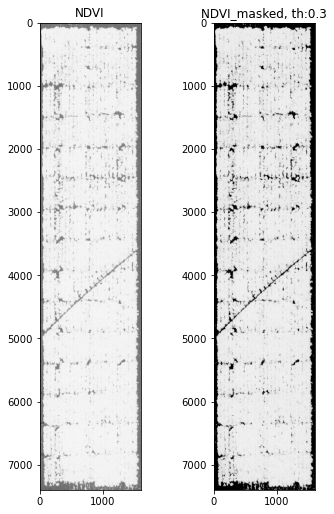

In [6]:
# 1. calculate NDVI
ndvi = improc.calc_spec_idx((4, 5), field_image)
#ndvi = (field_image[9] - field_image[5])/ (field_image[9] + field_image[5])

# ndvi = np.where(ndvi > 0, ndvi, 0)
# ndvi = np.where(ndvi > 1, 0, ndvi)
print(ndvi.shape, np.min(ndvi), np.max(ndvi))

# 2. choose ndvi threshold
config.NDVI_TH = 0.3

# 3. create a boolean mask of pixels > ndvi_th
mask = np.where(ndvi > config.NDVI_TH, True, False)


# 4. apply mask to cropped image
ndvi_masked = np.multiply(ndvi, mask)
print(f"mean value: {np.mean(ndvi_masked, where=mask)}")

# 5. Display the images as one figure.
fig, axs = plt.subplots(1, 2)
axs[0].imshow(ndvi, cmap="gray")

axs[0].set_title("NDVI")

axs[1].imshow(ndvi_masked, cmap="gray")
axs[1].set_title(f"NDVI_masked, th:{config.NDVI_TH}")

fig.tight_layout()
fig.set_figheight(8)

# Congratulations! You have a field_image with all ten bands, and a mask to segment the background out from the vegetation.

In [7]:
# save the field_image array to disk for use in other notebooks
# this will be an np.array object, which can then be loaded using np.load()
array_filename = Path.cwd() / config.data_export_path / f"{config.project_stub}_{config.data_acquisition_date}_fieldimage"
mask_filename = Path.cwd() / config.data_export_path / f"{config.project_stub}_{config.data_acquisition_date}_mask"
np.save(file=array_filename, arr=field_image)
np.save(file=mask_filename, arr=mask)


# Define the NDSIs 
NDSIs are defined by the equation $\frac{a-b}{a+b}$, where a and b are different color bands taken from the available channels in the field image. There are 10 channels available on data taken from the camera utilized for this dataset, which would yield $\frac {10!}{(10-2)!}=90$ combinations. However, half of those would be the inverse of the other half: $\frac{a-b}{a+b}$ vs. $\frac{b-a}{b+a}$.

The inversed NDSI features would be very highly autocorrelated with their partner, and would ultimately need to be removed from the dataset during dimensional reduction. Instead we choose to take only the unique permutations, resulting in $\frac {10!}{2!(10-2)!}=45$ NDSI features to calculate.


In [8]:
def chan_order_correct(img_chan_dict):
    """ are the channel orders correct from what we have previously observed? return true """
    alpha_order = [
        "blue",
        "blue-444",
        "green",
        "green-531",
        "nir",
        "red",
        "red-650",
        "red-edge",
        "red-edge-705",
        "red-edge-740",
    ]
    if False in [img_chan_dict.get(img_chan) == band_name for band_name, img_chan in zip(alpha_order, img_chan_dict)]:
        return False
    else:
        return True
    
img_chan = {key: value for key, value in enumerate(config.camera_wl)}

if chan_order_correct:
    ndsi_list = [combo for combo in combinations(iter(img_chan), 2)]

    ndsi_name_list = [
        f"{img_chan.get(combo[0])}-{img_chan.get(combo[1])}" for combo in ndsi_list
    ]

    print(f"There are {len(ndsi_list)} unique combinations in contained in ndsi_list.")
else:
    print("The order of the img_chan_dict is not alphabetical, which would lead to a different set of NDSIs than expected.")

There are 45 unique combinations in contained in ndsi_list.


# create an image stack with a channel for each NDSI in our list
We need to perform the calculations to generate a new image stack, with one channel for each NDSI. We can use the function calc_spec_idx_from_combo() to create the stack of np.arrays. It takes a tuple of two ints, with each tuple representing a combination of two image channels. 

In [9]:
# create ndsi stack
ndsi_stack = np.stack([improc.calc_spec_idx(combo, field_image) for combo in ndsi_list])

print(f"ndsi_stack.shape={ndsi_stack.shape}")
ndsistack_filename = Path.cwd() / config.data_export_path / f"{config.project_stub}_{config.data_acquisition_date}_ndsi"
np.save(file=ndsistack_filename, arr=ndsi_stack)


ndsi_stack.shape=(45, 7400, 1600)


# Calculate boundary of plots
In the case of the potato, the lower left of the field is plot 0, with plot_id incrementing with range, then starting again from the bottom. 

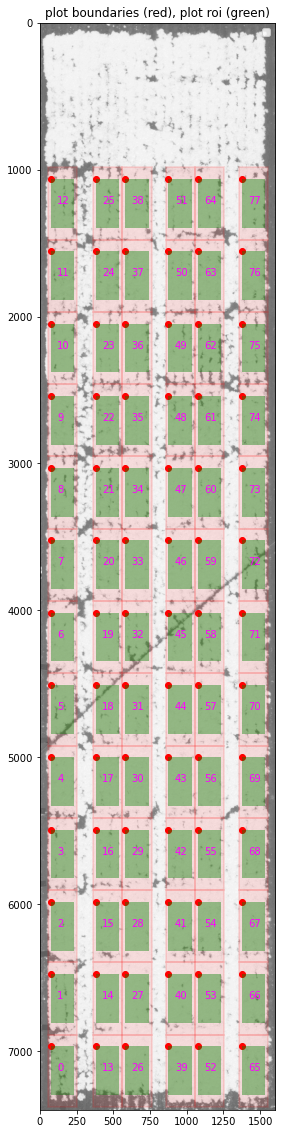

In [10]:
pc = PlotCoordinates()
use_config_val = True

# variables
if use_config_val:
    plot_shape = config.plot_shape  # w,h
    edge_buf = config.edge_buf  # buffer around edge of plot
    num_ranges = config.num_ranges
    y_offset = config.plot_offset[0]  # offset from bottom of image
    x_offset = config.plot_offset[1]
    roi_shape = pc.get_roi_shape(plot_shape=config.plot_shape, edge_buf=config.edge_buf)
else:
    plot_shape = (200, 400)  # w,h
    edge_buf = 50  # buffer around edge of plot
    num_ranges = 12
    y_offset = 60
    x_offset = 20
    roi_shape = pc.get_roi_shape(plot_shape, edge_buf) # smaller coordinates within plot_shape

# set the x origins for the plots, and the y origins will be calculated
x_origins = [50 + x_offset, 355 + x_offset, 555 + x_offset, 850 + x_offset, 1050 + x_offset, 1350 + x_offset]
y_origins = [
    ndsi_stack.shape[1] + y_offset - plot_shape[1] * y
    for y in range(1, num_ranges + 1)
]

# use these values to calculate the plot coordinates
plot_coords = list(product(x_origins, y_origins))
roi_coords = [
    pc.get_roi_coord(plot_coord=plot_coord, edge_buf=edge_buf)
    for plot_coord in plot_coords
]

# now plot them for verification on the NDVI image
plot_id_list = pc.plot_boundaries(
    img=ndvi,
    plot_coords=plot_coords,
    roi_coords=roi_coords,
    plot_shape=plot_shape,
    roi_shape=roi_shape,
)

# A note on calculating mean values. 
### You have to exclude the background!
We need to be careful when we calculate our mean values for the roi. We can't include values from the background. To exclude these, we utilize the NDVI thresholded mask we created above. Just to see how it works, here is a simple test of the mask on a very small array. A mask is provided that excludes values less than 1. They are not included in the number of pixels when the average value is calculated, as seen below. 

In [11]:
roi = np.array([0, 1, 2, 3])
roi_mask = np.where(roi >= 1, True, False)
roi_avg4 = (1 + 2 + 3) / 4
roi_avg3 = (1 + 2 + 3) / 3

print(f" sum(roi)/4 = {np.sum(roi)/4}, sum(roi)/3 = {sum(roi)/3}")
print(roi_mask)
print(f"np.mean(roi) = {np.mean(roi)}")
print(f"np.mean(roi, where=mask) = {np.mean(roi, where=roi_mask)}")


 sum(roi)/4 = 1.5, sum(roi)/3 = 2.0
[False  True  True  True]
np.mean(roi) = 1.5
np.mean(roi, where=mask) = 2.0


# calculate the NDSI means and export the dataframe as a *.csv
We want to use this data in other notebooks for modeling, so lets combine it with our ground truth data. After it is joined on the plot id, we export it to the processed data path. 

In [12]:
ndsi_means = np.stack(
    [
        [improc.ndsi_mean(arr=ndsi, origin=origin, shape=roi_shape, mask=mask) for ndsi in ndsi_stack]
        for origin in roi_coords
    ]
)

df = pd.read_csv(config.ground_truth_path)[["plot_id", "yield"]]

ndsi_df = pd.concat([pd.DataFrame(plot_id_list, columns=["plot_id"]), pd.DataFrame(ndsi_means, columns=ndsi_name_list)], axis=1)

export_df = df.join(ndsi_df.set_index('plot_id'), on='plot_id')
 
export_df.to_csv(os.path.join(config.data_export_path, f'{config.data_acquisition_date}_df.csv'))


In [13]:
# # update parameters and save them for posterity
config.export_config()

# params = {
#     "project_stub": PROJ_STR,
#     "image_format": "*.tif",
#     "data_acquisition_date": DATE_STR,
#     "NDVI_threshold": NDVI_TH,
#     "data_import_path": Path.cwd() / "data" / "raw" / DATE_STR,
#     "data_export_path": Path.cwd() / "data" / "processed" / DATE_STR,
#     "plot_export_path": Path.cwd() / "image_export" ,
#     "ground_truth_path": Path.cwd() / "data" / "raw" / GT_STR,
#     "field_dim": FIELD_DIM,
#     "field_origin": FIELD_ORIGIN,
#     "field_angle" : FIELD_ANGLE,
#     "roi_x_offset": 0,
#     "roi_y_offset": 0
# }

# # export the params file for reference
# with open(
#     params["data_export_path"]
#     / (str(date.today()) + "_" + params["data_acquisition_date"] + "_" + "params.yaml"),
#     "w",
# ) as file:
#     documents = yaml.dump(params, file)


# Deep Learning image export
For deep learning, we need images. The exact format of those images is determined by the model and type of deep learning you're doing. I don't know that yet. So this notebook ends here. 